In [1]:
from autoML import AutoML
from autosklearn.regression import AutoSklearnRegressor
import pandas as pd
import sklearn as sk
import numpy as np

## Loading the data

In [2]:
data = pd.read_csv("datasets/Fish.csv")
print(data.head())
print("Data shape:", data.shape)

  Species  Weight  Length1  Length2  Length3   Height   Width
0   Bream   242.0     23.2     25.4     30.0  11.5200  4.0200
1   Bream   290.0     24.0     26.3     31.2  12.4800  4.3056
2   Bream   340.0     23.9     26.5     31.1  12.3778  4.6961
3   Bream   363.0     26.3     29.0     33.5  12.7300  4.4555
4   Bream   430.0     26.5     29.0     34.0  12.4440  5.1340
Data shape: (159, 7)


## Split into test and training set

In [3]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2)

train.shape, test.shape

((127, 7), (32, 7))

## Get knowledge over dataset

In [4]:
train.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
75,Perch,51.5,15.0,16.2,17.2,4.5924,2.6316
154,Smelt,12.2,11.5,12.2,13.4,2.0904,1.3936
20,Bream,575.0,31.3,34.0,39.5,15.1285,5.5695
148,Smelt,9.7,10.4,11.0,12.0,2.1960,1.3800
36,Roach,69.0,16.5,18.2,20.3,5.2983,2.8217


The dataset has 7 attributes (incl. the target attribute *weight*). The attributes *Length1*, *Length2*, *Length3*, *Height* and *Width* are numerical. The attribute *Species* is nominal.

In [5]:
train.describe()

,Weight,Length1,Length2,Length3,Height,Width
count,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000
mean,400.059843,26.048819,28.196063,30.960630,8.917554,4.409780
std,361.278512,9.944639,10.674085,11.560147,4.393953,1.749036
min,6.700000,9.300000,9.800000,10.800000,1.728400,1.047600
25%,120.000000,19.000000,21.000000,22.650000,5.781900,3.323300
50%,270.000000,24.100000,26.500000,29.200000,7.585200,4.234000
75%,685.000000,33.600000,36.200000,39.700000,12.143400,5.872800
max,1600.000000,56.000000,60.000000,64.000000,18.957000,8.142000


In [6]:
set(train["Species"])

{'Bream', 'Parkki', 'Perch', 'Pike', 'Roach', 'Smelt', 'Whitefish'}

<AxesSubplot:ylabel='Species'>

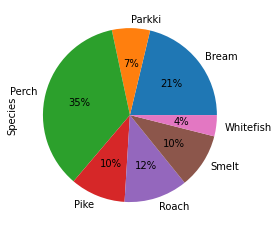

In [7]:
train.groupby("Species").size().plot.pie(ylabel="Species", autopct=lambda val: "{:0.0f}%".format(val))

<AxesSubplot:>

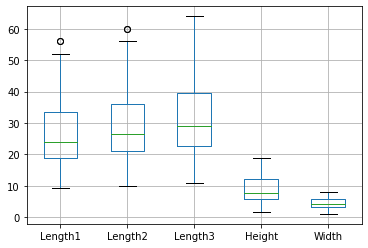

In [8]:
train.drop("Weight", axis=1).boxplot()

## Initialize all regressors

In [9]:
class DummyRegressor():
    def fit(self, X_train, y_train):
        self.range = min(y_train), max(y_train)
    
    def predict(self, X_test):
        return np.random.uniform(self.range[0], self.range[1], [len(X_test)])
    
    def get_params(self, deep=True):
        return {}      

regressors = {
    "dummy": DummyRegressor(),
    "decisionTree": sk.tree.DecisionTreeRegressor(),
    "linearRegression": sk.linear_model.LinearRegression(),
    "randomForestRegressor": sk.ensemble.RandomForestRegressor(),
    "auto-sklearn" : AutoSklearnRegressor(
        time_left_for_this_task = 60,
        per_run_time_limit = 10,
        n_jobs=-1
    ),
    # our regressors
    "autoML": AutoML(fitting_time=60, n_jobs=-1),
}

## Check training performance

In [10]:
from sklearn.metrics import make_scorer

def relative_squared_error(y_pred, y_test):
    avg = np.average(y_test)
    error = y_pred-y_test
    mean_error = -(y_test-avg)
    return np.sum(error**2)/np.sum(mean_error**2)

def correlation_coefficient(y_pred, y_test):
    return np.corrcoef(np.array([y_pred, y_test]))[0][1]

def check_stats(predictor, X, y, name):
    
    scoring = {
        "MSE": make_scorer(sk.metrics.mean_absolute_error),
        "RSE": make_scorer(relative_squared_error),
        "CorrCoef": make_scorer(correlation_coefficient)
    }

    result = sk.model_selection.cross_validate(predictor, X, y, scoring=scoring)

    fit_time = np.mean(result["fit_time"])
    score_time = np.mean(result["score_time"])
    mse = np.mean(result["test_MSE"])
    rse = np.mean(result["test_RSE"])
    corr = np.mean(result["test_CorrCoef"])

    return name, mse, rse, corr, fit_time, score_time

In [11]:
def get_performance(regressors, X, y):
    # check stats of all regressors
    columns = ["Name", "MAE", "RSE", "Corr", "Fit time", "Score time"]
    rows = []
    for regressor_name in regressors:
        stats = check_stats(regressors[regressor_name], X, y, regressor_name)
        rows.append(stats)
    stats = pd.DataFrame(rows, columns=columns)
    return stats

### Preprocessing - Removing "Species"

In [12]:
X_rem = train.drop(["Weight", "Species"], axis=1)
y_rem = train["Weight"]

stats_rem = get_performance(regressors, X_rem, y_rem)
stats_rem

{'params': {'n_estimators': 512, 'criterion': 'mae', 'min_impurity_decrease': 0.09661521337863879, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 1}, 'regressor': RandomForestRegressor(criterion='mae', max_features=1,
                      min_impurity_decrease=0.09661521337863879,
                      min_samples_split=3, n_estimators=512), 'score': 0.9679603696857155}
/home/alex/projects/autoML/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alex/projects/autoML/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alex/projects/autoML/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron

,Name,MAE,RSE,Corr,Fit time,Score time
0,dummy,568.451118,2.278452,0.011621,0.000809,0.001295
1,decisionTree,45.477323,0.052294,0.976333,0.001626,0.001555
2,linearRegression,93.453119,0.143160,0.939690,0.001548,0.001576
3,randomForestRegressor,39.146948,0.033094,0.986336,0.092714,0.008726
4,auto-sklearn,30.729660,0.032089,0.990273,62.425277,0.057619
5,autoML,33.633454,0.032547,0.987478,60.502814,0.029713


### Preprocessing - One-hot encoding "Species"

In [13]:
train_encoded = pd.get_dummies(train, columns=["Species"])
train_encoded.head()

,Weight,Length1,Length2,Length3,Height,Width,Species_Bream,Species_Parkki,Species_Perch,Species_Pike,Species_Roach,Species_Smelt,Species_Whitefish
75,51.5,15.0,16.2,17.2,4.5924,2.6316,0,0,1,0,0,0,0
154,12.2,11.5,12.2,13.4,2.0904,1.3936,0,0,0,0,0,1,0
20,575.0,31.3,34.0,39.5,15.1285,5.5695,1,0,0,0,0,0,0
148,9.7,10.4,11.0,12.0,2.1960,1.3800,0,0,0,0,0,1,0
36,69.0,16.5,18.2,20.3,5.2983,2.8217,0,0,0,0,1,0,0


In [14]:
X_enc = train_encoded.drop("Weight", axis=1)
y_enc = train_encoded["Weight"]

stats_enc = get_performance(regressors, X_enc, y_enc)
stats_enc

{'params': {'hidden_layer_depth': 1, 'num_nodes_layer_0': 29, 'num_nodes_layer_1': 42, 'num_nodes_layer_2': 66, 'max_iter': 10000, 'activation': 'relu', 'alpha': 0.1, 'learning_rate_init': 0.2025736355509042, 'hidden_layer_sizes': (29,)}, 'regressor': MLPRegressor(alpha=0.1, hidden_layer_sizes=(29,),
             learning_rate_init=0.2025736355509042, max_iter=10000), 'score': 0.9726468680428895}
{'params': {'n_estimators': 268, 'learning_rate': 0.22217550985154144, 'loss': 'square'}, 'regressor': AdaBoostRegressor(learning_rate=0.22217550985154144, loss='square',
                  n_estimators=268), 'score': 0.9638552222649366}
/home/alex/projects/autoML/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alex/projects/autoML/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:6

,Name,MAE,RSE,Corr,Fit time,Score time
0,dummy,611.594929,3.110712,-0.152392,0.000717,0.001382
1,decisionTree,48.516677,0.053909,0.974918,0.002106,0.002053
2,linearRegression,68.669054,0.074427,0.967565,0.003775,0.003213
3,randomForestRegressor,38.710976,0.034854,0.986076,0.098383,0.010954
4,auto-sklearn,32.351100,0.025905,0.990980,60.049008,0.100288
5,autoML,39.320972,0.040285,0.987060,60.437026,0.024070


### Preprocessing - One-hot encoding + standardization

In [15]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(X_enc)

X_std = pd.DataFrame(x_scaled, columns=X_enc.columns)
y_std = y_enc

X_std.index = y_std.index

stats_std = get_performance(regressors, X_std, y_std)
stats_std

{'params': {'hidden_layer_depth': 1, 'num_nodes_layer_0': 93, 'num_nodes_layer_1': 112, 'num_nodes_layer_2': 58, 'max_iter': 10000, 'activation': 'relu', 'alpha': 0.1, 'learning_rate_init': 0.5, 'hidden_layer_sizes': (93,)}, 'regressor': MLPRegressor(alpha=0.1, hidden_layer_sizes=(93,), learning_rate_init=0.5,
             max_iter=10000), 'score': 0.9854502464571029}
{'params': {'hidden_layer_depth': 1, 'num_nodes_layer_0': 45, 'num_nodes_layer_1': 50, 'num_nodes_layer_2': 43, 'max_iter': 10000, 'activation': 'relu', 'alpha': 0.1, 'learning_rate_init': 0.5, 'hidden_layer_sizes': (45,)}, 'regressor': MLPRegressor(alpha=0.1, hidden_layer_sizes=(45,), learning_rate_init=0.5,
             max_iter=10000), 'score': 0.9840945132242499}
{'params': {'hidden_layer_depth': 1, 'num_nodes_layer_0': 36, 'num_nodes_layer_1': 65, 'num_nodes_layer_2': 32, 'max_iter': 10000, 'activation': 'relu', 'alpha': 0.1, 'learning_rate_init': 0.5, 'hidden_layer_sizes': (36,)}, 'regressor': MLPRegressor(alpha=0.1

,Name,MAE,RSE,Corr,Fit time,Score time
0,dummy,597.736997,2.533555,-0.068944,0.001025,0.001736
1,decisionTree,45.148092,0.043855,0.979341,0.005253,0.004592
2,linearRegression,68.669054,0.074427,0.967565,0.008508,0.003521
3,randomForestRegressor,42.376418,0.044773,0.983279,0.118697,0.014364
4,auto-sklearn,35.073536,0.034647,0.988005,60.742079,0.129972
5,autoML,29.408498,0.019268,0.993547,61.105136,0.008895


The performance checks show that the preprocessing step of one-hot encode the "Species" column is better than removing the column and has not real benefit over additional standardization.
Therefore one-hot encoding is enough.

## Checking performance on test set

In [16]:
from time import time

def get_test_performance(regressor, X, y):   
    t = time()
    y_pred = regressor.predict(X)
    t = time() - t
    
    mae = sk.metrics.mean_absolute_error(y_pred, y)
    rse = relative_squared_error(y_pred, y)
    corr = correlation_coefficient(y_pred,y)
    
    return mae, rse, corr, t
    

In [17]:
X_test = pd.get_dummies(test.drop("Weight", axis=1), columns=["Species"])
y_test = test["Weight"]

X_train = pd.get_dummies(train.drop("Weight", axis=1), columns=["Species"])
y_train = train["Weight"]

missing_cols = set(X_train.columns) - set(X_test.columns)
for c in missing_cols:
    X_test[c] = 0
X_test = X_test[X_train.columns]

test_performance = []
for name in regressors:
    regressor = regressors[name]
    train_t = time()
    regressor.fit(X_train, y_train)
    train_t = time() - train_t
    mae, rse, corr, test_t = get_test_performance(regressor, X_test, y_test)
    test_performance.append((name, mae, rse, corr, train_t, test_t))

test_stats = pd.DataFrame(test_performance, columns=["Name", "MAE", "RSE", "CorrCoeff", "TrainTime", "TestTime"])
test_stats

{'params': {'n_estimators': 282, 'learning_rate': 0.3463185307684342, 'loss': 'linear'}, 'regressor': AdaBoostRegressor(learning_rate=0.3463185307684342, n_estimators=282), 'score': 0.9687125366116403}


,Name,MAE,RSE,CorrCoeff,TrainTime,TestTime
0,dummy,704.694906,5.496348,-0.198628,0.000041,0.000051
1,decisionTree,71.609375,0.078076,0.960947,0.002892,0.001437
2,linearRegression,87.136478,0.127700,0.944315,0.001714,0.001005
3,randomForestRegressor,59.523854,0.065749,0.968651,0.122971,0.009737
4,auto-sklearn,42.595852,0.035162,0.983628,62.183939,0.205178
5,autoML,62.644878,0.059866,0.972289,60.503376,0.037539
